In [22]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import minimize_scalar

from numpy.linalg import inv, norm
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from itertools import chain
import random

import matplotlib as mpl
from matplotlib import rc

#mpl.rcParams.update({'font.size': 16})
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)
#rc('legend', fontsize=12)
mpl.rcParams['savefig.dpi'] = 1200
mpl.rcParams['text.usetex'] = True  # not really needed


np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

## Data

In [24]:
def get_data(t, n, p, B_star, sigma):
    # covariates
    X = np.random.randn(n, p)

    # models
    Y = X @ B_star + sigma * np.random.randn(n, t)
    return X, Y

## Estimates

In [25]:
def get_HPS_estimator(X, Y, r):
    A_hat = Y.T @ X @ np.linalg.inv(X.T @ X) @ X.T @ Y
    U, D, V = np.linalg.svd(A_hat)
#    print(U.shape)
    U = U[:, :r]
    BA_hat = np.linalg.inv(X.T @ X) @ X.T @ Y @ U @ U.T
    
    return BA_hat

def get_excess_risk(X, Y, t, r, B_star):
    BA_hat = get_HPS_estimator(X, Y, r)
    beta_hat = BA_hat[:, t-1]
    beta_star = B_star[:, t-1]
    return np.linalg.norm(beta_hat - beta_star) **2

def get_bias_plus_variance(X, Y, t, r, B_star, sigma):
    A_hat = Y.T @ X @ np.linalg.inv(X.T @ X) @ X.T @ Y
    U, D, Vt = np.linalg.svd(A_hat)
    U = U[:, :r]
    U_A = U @ U.T
    a_t_hat = U_A[:, t-1]
    bias = np.linalg.norm(B_star @ a_t_hat - B_star[:, t-1]) **2
    var = sigma**2 * np.linalg.norm(a_t_hat)**2 * np.trace(np.linalg.inv(X.T @ X))
    return bias + var

def get_estimate(B_star, n, p, r, sigma):
    U, D, V = np.linalg.svd(B_star.T @ B_star)
    U = U[:, :r]
    A_star = U @ U.T
    bias = np.linalg.norm(B_star @ A_star[:, t-1] - B_star[:, t-1]) **2
    var = sigma**2 * np.linalg.norm(A_star[:, t-1])**2 * float(p) / (n - p)
    return bias + var
#thm_avg_loss_list = [(1 - r / float(t)) * d**2 + (float(r) / t) * (sigma**2 * p) / (i - p) for i in n_list]

## Figure 4a: select width

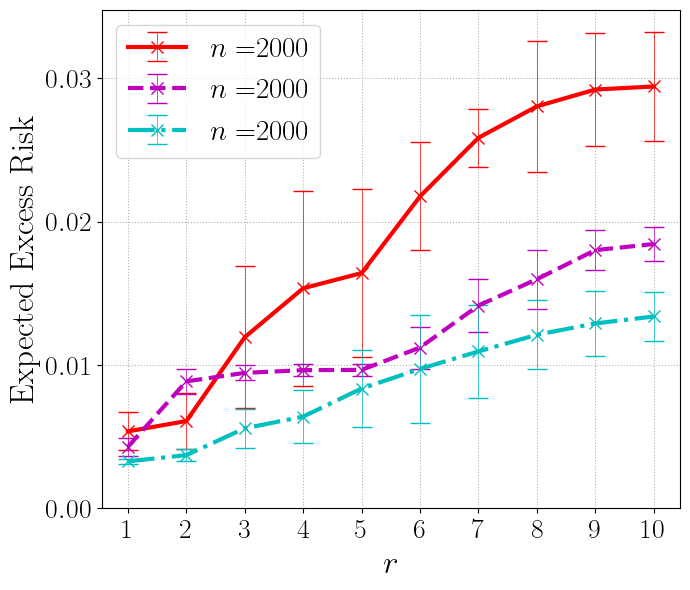

In [26]:
p = 100
t = 10
sigma = 0.5

#bias_var_list = []
#thy_list = []
#stl_list = [sigma**2 * p / (n - p) for i in range(t)]

def run_width_selection(n, p, t, mu, sigma, seeds=3):
    agg_list = [[] for i in range(t)]

    for i in range(seeds):
        emp_list = []
        width_list = [i for i in range(1, t+1)]


        beta_0 = np.random.randn(p, 1) / math.sqrt(p)
        B_star = beta_0 @ np.ones((1, t)) + mu * np.random.randn(p, t) / math.sqrt(p)
        beta_star = B_star[:, t-1]
        #U, s, Vt = np.linalg.svd(B_star)
        #print(s)

        X, Y = get_data(t, n, p, B_star, sigma)

        for j in width_list:
            risk = get_excess_risk(X, Y, t, j, B_star)
            agg_list[j-1].append(risk)
#            emp_list.append(risk)
            
#        agg_list.append(emp_list)

    return agg_list

plt.figure(figsize=(7,6))

# test 3
n = 1000
mu = 0.05

width_list = [i for i in range(1, t+1)]
agg_list3 = run_width_selection(n, p, t, mu, sigma)
mean3 = [np.mean(x) for x in agg_list3]
std3 = [np.std(x) for x in agg_list3]


# test 2
n = 1500
mu = 0.05

width_list = [i for i in range(1, t+1)]
agg_list2 = run_width_selection(n, p, t, mu, sigma)
mean2 = [np.mean(x) for x in agg_list2]
std2 = [np.std(x) for x in agg_list2]


# test 1
n = 2000
mu = 0.05


plt.errorbar(width_list, mean3, yerr=std3, elinewidth=0.5, capthick=1, capsize=7, c='r', lw=3, marker='x', markersize=8, label = r'$n=$' + r'$\mathrm{'+str(n)+'}$')

plt.errorbar(width_list, mean2, yerr=std2, elinewidth=0.5, capthick=1, capsize=7, c='m', lw=3, ls='dashed', marker='x', markersize=8, label = r'$n= $' + r'$\mathrm{'+str(n)+'}$')

#plt.plot(width_list, emp_list1, label = r'$n=$' + str(n) + r', $\mu=$' + str(mu))
plt.xlabel(r'$r$', fontsize=24)
plt.ylabel(r'$\mathrm{Expected~Excess~Risk}$', fontsize=24)


width_list = [i for i in range(1, t+1)]
agg_list1 = run_width_selection(n, p, t, mu, sigma)
mean1 = [np.mean(x) for x in agg_list1]
std1 = [np.std(x) for x in agg_list1]
plt.errorbar(width_list, mean1, yerr=std1, elinewidth=0.5, capthick=1, capsize=7, c='c', lw=3, ls='dashdot', marker='x', markersize=8, label = r'$n=$' + r'$\mathrm{'+str(n)+'}$')


plt.yticks(np.arange(0, 0.035, 0.01),fontsize=20)
plt.xticks(np.arange(1, 11, 1), fontsize=20)

plt.grid(ls = ':', lw=0.8)
plt.legend(fontsize=21, loc='upper left')#,loc=3)
plt.tight_layout()
plt.savefig('multitask_width.pdf')

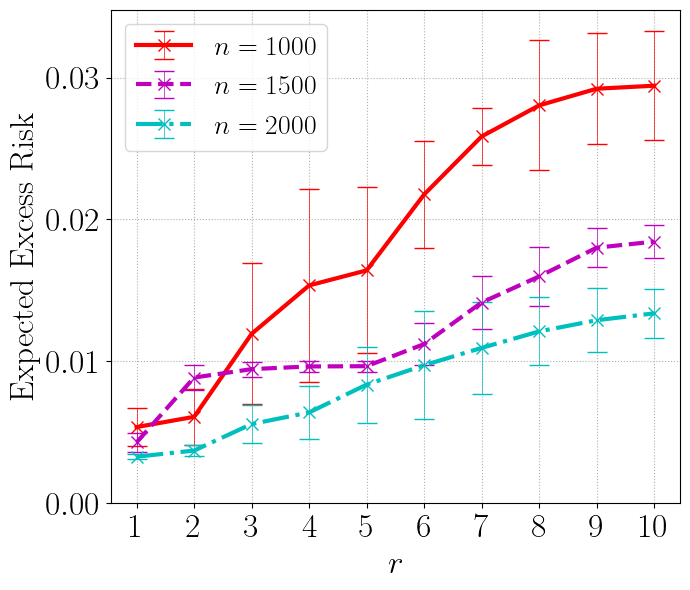

In [36]:
plt.figure(figsize=(7,6))
plt.errorbar(width_list, mean3, yerr=std3, elinewidth=0.5, capthick=1, capsize=7, c='r', lw=3, marker='x', markersize=8, label = r'$n= 1000$')# + r'$\mathrm{'+str(n)+'}$')

plt.errorbar(width_list, mean2, yerr=std2, elinewidth=0.5, capthick=1, capsize=7, c='m', lw=3, ls='dashed', marker='x', markersize=8, label = r'$n= 1500$')# + r'$\mathrm{' +str(n)+'}$')

#plt.plot(width_list, emp_list1, label = r'$n=$' + str(n) + r', $\mu=$' + str(mu))
plt.xlabel(r'$r$', fontsize=24)
plt.ylabel(r'$\mathrm{Expected~Excess~Risk}$', fontsize=24)


plt.errorbar(width_list, mean1, yerr=std1, elinewidth=0.5, capthick=1, capsize=7, c='c', lw=3, ls='dashdot', marker='x', markersize=8, label = r'$n= 2000$')# + r'$\mathrm{'+str(n)+'}$')


plt.yticks(np.arange(0, 0.035, 0.01),fontsize=24)
plt.xticks(np.arange(1, 11, 1), fontsize=24)

plt.grid(ls = ':', lw=0.8)
plt.legend(fontsize=20, loc='upper left')#,loc=3)
plt.tight_layout()
plt.savefig('multitask_width.pdf')

## Figure 4b: information transfer

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


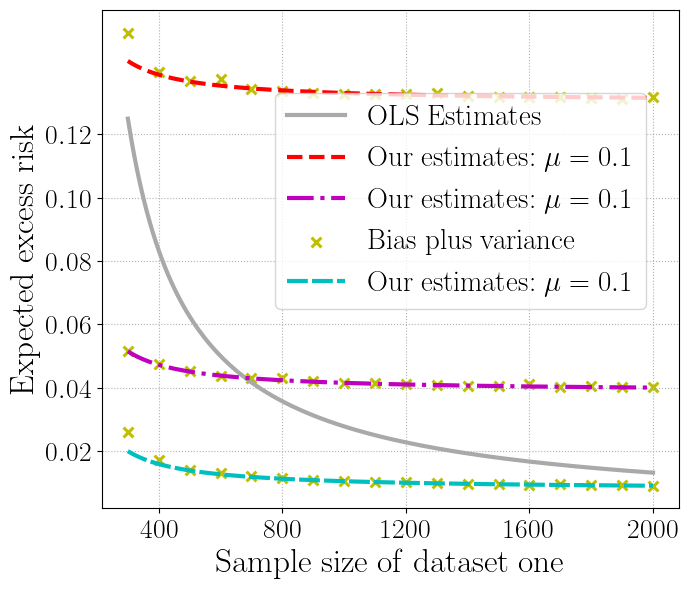

In [28]:
p = 100
n_list = [p * i for i in range(3, 21)]
n_extended_list = [10 * i for i in range(30, 201)]
sigma = 0.5

def run_information_transfer(n_list, n_extended_list, p, sigma, mu):
    bias_var_list1 = []
    thy_list1 = []
    beta_0 = np.random.randn(p, 1) / math.sqrt(p)
    B_star = beta_0 @ np.ones((1, t)) + mu * np.random.randn(p, t) / math.sqrt(p)
    r = 1

    for n in n_list:
        X, Y = get_data(t, n, p, B_star, sigma)

        bias_var = get_bias_plus_variance(X, Y, t, r, B_star, sigma)
#        bias_var = get_excess_risk(X, Y, t, r, B_star)
        bias_var_list1.append(bias_var)

    for n in n_extended_list:
        estimate = get_estimate(B_star, n, p, r, sigma)
        thy_list1.append(estimate)
        
    return bias_var_list1, thy_list1

plt.figure(figsize=(7,6))

# STL
stl_list1 = [sigma**2 * p / (n - p) for n in n_extended_list]


# negative transfer
mu = 0.35
negative_list, negative_est_list = run_information_transfer(n_list, n_extended_list, p, sigma, mu)


# transition
mu = 0.2
transition_list, transition_est_list = run_information_transfer(n_list, n_extended_list, p, sigma, mu)


# positive transfer
mu = 0.1
positive_list, positive_est_list = run_information_transfer(n_list, n_extended_list, p, sigma, mu)


plt.plot(n_extended_list, stl_list1, c='darkgrey', lw=3, label=r'$\mathrm{OLS~Estimates}$')

plt.scatter(n_list, negative_list, marker='x', c='y',  s=50, lw=2.2)
plt.plot(n_extended_list, negative_est_list, c='r', lw=3, ls='dashed', label=r'$\mathrm{Our~estimates}$' + r'$:\mu = \mathrm{'+str(mu)+'}$')

plt.scatter(n_list, transition_list, marker='x', c='y',  s=50, lw=2.2)
plt.plot(n_extended_list, transition_est_list, c='m', lw=3, ls='dashdot', label=r'$\mathrm{Our~estimates}$' + r'$:\mu = \mathrm{'+str(mu)+'}$')

plt.scatter(n_list, positive_list, marker='x', c='y',  s=50, lw=2.2, label=r'$\mathrm{Bias~plus~variance}$')
plt.plot(n_extended_list, positive_est_list, c='c', lw=3, ls=(0, (5, 1)), label=r'$\mathrm{Our~estimates}$' + r'$:\mu = \mathrm{'+str(mu)+'}$')

plt.xlabel(r'$\mathrm{Sample~size~of~dataset~one}$', fontsize=24)
plt.ylabel(r'$\mathrm{Expected~excess~risk}$', fontsize=24)

plt.yticks(np.arange(0.02, 0.13, 0.02), fontsize=20)
plt.xticks(np.arange(400, 2100, 400), fontsize=20)

plt.grid(ls = ':', lw=0.8)
lgd = plt.legend(fontsize=21, loc=(0.3,0.4))
plt.tight_layout()
plt.savefig('multitask_transfer.eps')

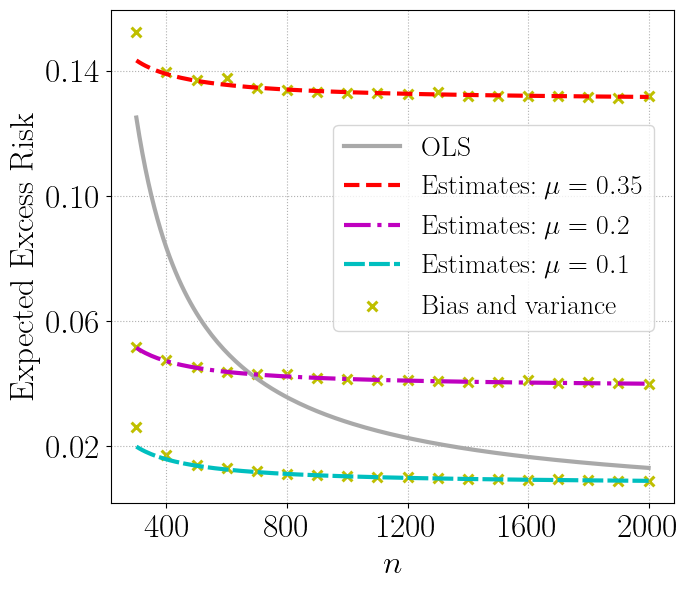

In [35]:
plt.figure(figsize=(7,6))

plt.plot(n_extended_list, stl_list1, c='darkgrey', lw=3, label=r'$\mathrm{OLS}$')

plt.plot(n_extended_list, negative_est_list, c='r', lw=3, ls='dashed', label=r'$\mathrm{Estimates}$' + r'$:\mu = 0.35$')


plt.plot(n_extended_list, transition_est_list, c='m', lw=3, ls='dashdot', label=r'$\mathrm{Estimates}$' + r'$:\mu = 0.2$')

plt.plot(n_extended_list, positive_est_list, c='c', lw=3, ls=(0, (5, 1)), label=r'$\mathrm{Estimates}$' + r'$:\mu = 0.1$')

plt.scatter(n_list, negative_list, marker='x', c='y',  s=50, lw=2.2)

plt.scatter(n_list, transition_list, marker='x', c='y',  s=50, lw=2.2)

plt.scatter(n_list, positive_list, marker='x', c='y',  s=50, lw=2.2, label=r'$\mathrm{Bias~and~variance}$')

plt.xlabel(r'$n$', fontsize=24)
plt.ylabel(r'$\mathrm{Expected~Excess~Risk}$', fontsize=24)

plt.yticks(np.arange(0.02, 0.16, 0.04), fontsize=24)
plt.xticks(np.arange(400, 2100, 400), fontsize=24)

plt.grid(ls = ':', lw=0.8)
lgd = plt.legend(fontsize=20, loc=(0.395,0.35))
plt.tight_layout()
plt.savefig('multitask_transfer.pdf')